#  NREL Resource Extraction Tool (NREL-rex)

This notebook demonstrates data slicing for the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS). These slicing methods would also work with the WIND Toolkit data available via HSDS at /nrel/wtk/

Please consult the README file for setup instructions prior to running this notebook.

This example will also be using NREL's Resource Extraction Tools package [`NREL-rex`](https://github.com/nrel/rex).
If running this example in Github codespaces, the package will already be installed.  Otherwise it can be installed with pip:
```
pip install NREL-rex
```
or with conda:
```
conda install nrel-rex
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
from rex import NSRDBX, WindX

# NSRSBX

In [2]:
nsrdb_file = '/nrel/nsrdb/v3/nsrdb_2018.h5'

In [3]:
# NSRDBX is a wrapper on h5py and h5pyd that simplifies extraction of NSRDB data
# It automatically converts the meta data to a pandas DataFrame
# The time_index to a pandas DatatimeIndex
# And unscales NSRDB datasets
# NOTE: the syntax for extracting datasets is different from h5py/h5pyd!!

with NSRDBX(nsrdb_file, hsds=True) as f:
    meta = f.meta
    display(meta.head())
    time_index = f.time_index
    display(time_index)
    dni = f['dni', ::2, :10]

dni.shape

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
gid,,,,,,,,,,
0,-19.99,-175.259995,0.0,13,None,None,None,None,-9999,210
1,-19.99,-175.220001,0.0,13,None,None,None,None,-9999,210
2,-19.99,-175.179993,0.0,13,None,None,None,None,-9999,210
3,-19.99,-175.139999,0.0,13,None,None,None,None,-9999,210
4,-19.99,-175.100006,0.0,13,None,None,None,None,-9999,210


DatetimeIndex(['2018-01-01 00:00:00+00:00', '2018-01-01 00:30:00+00:00',
               '2018-01-01 01:00:00+00:00', '2018-01-01 01:30:00+00:00',
               '2018-01-01 02:00:00+00:00', '2018-01-01 02:30:00+00:00',
               '2018-01-01 03:00:00+00:00', '2018-01-01 03:30:00+00:00',
               '2018-01-01 04:00:00+00:00', '2018-01-01 04:30:00+00:00',
               ...
               '2018-12-31 19:00:00+00:00', '2018-12-31 19:30:00+00:00',
               '2018-12-31 20:00:00+00:00', '2018-12-31 20:30:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 21:30:00+00:00',
               '2018-12-31 22:00:00+00:00', '2018-12-31 22:30:00+00:00',
               '2018-12-31 23:00:00+00:00', '2018-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17520, freq=None)

(8760, 10)

In [4]:
# NSRDBX also allows easy extraction of the nearest site to a desired (lat, lon) location:
coords = (39.741931, -105.169891)
with NSRDBX(nsrdb_file, hsds=True) as f:
    coords_df = f.get_lat_lon_df('dni', coords)

In [5]:
coords_df.reset_index()

,time_index,145809
0,2018-01-01 00:00:00+00:00,0
1,2018-01-01 00:30:00+00:00,0
2,2018-01-01 01:00:00+00:00,0
3,2018-01-01 01:30:00+00:00,0
4,2018-01-01 02:00:00+00:00,0
...,...,...
17515,2018-12-31 21:30:00+00:00,134
17516,2018-12-31 22:00:00+00:00,6
17517,2018-12-31 22:30:00+00:00,0
17518,2018-12-31 23:00:00+00:00,0


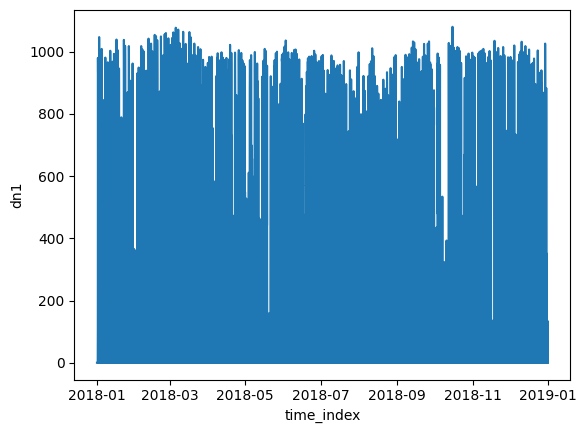

In [6]:
# sns.lineplot(x="time_index", y="dni", data=coords_df.reset_index())
data = coords_df.reset_index()
y_colname = list(data)[1]
data.rename(columns={y_colname: 'dn1'}, inplace=True)
sns.lineplot(x="time_index", y='dn1', data=data)
plt.show()

In [7]:
# NSRDBX can also filter on differnt meta data columns
region = 'Colorado'
with NSRDBX(nsrdb_file, hsds=True) as f:
    date = '2018-07-04 18:00:00'
    dni_map = f.get_timestep_map('dni', date, region=region, region_col='state')

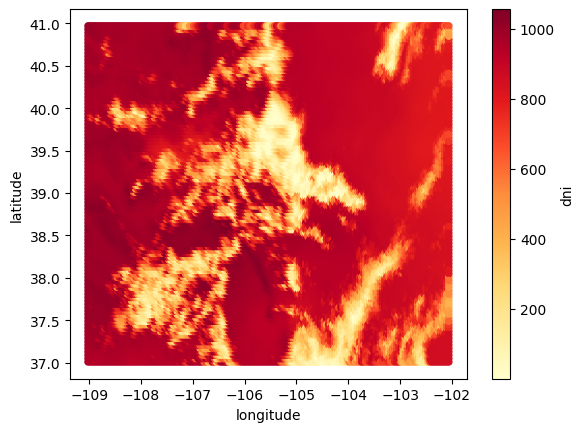

In [8]:
dni_map.plot.scatter(x='longitude', y='latitude', c='dni', colormap='YlOrRd')
plt.show()

In [9]:
# NSRDBX can also extract the variables need for SAM
nrel = (39.741931, -105.169891)
with NSRDBX(nsrdb_file, hsds=True) as f:
    nrel_sam_vars = f.get_SAM_lat_lon(nrel)

In [10]:
nrel_sam_vars

,Year,Month,Day,Hour,Minute,DNI,DHI,Wind Speed,Temperature
0,2018,1,1,0,0,0,0,0.5,-9.7
1,2018,1,1,0,30,0,0,0.5,-9.8
2,2018,1,1,1,0,0,0,0.5,-10.0
3,2018,1,1,1,30,0,0,0.6,-10.1
4,2018,1,1,2,0,0,0,0.7,-10.2
...,...,...,...,...,...,...,...,...,...
17515,2018,12,31,21,30,0,0,0.9,-8.5
17516,2018,12,31,22,0,0,0,0.8,-8.8
17517,2018,12,31,22,30,0,0,0.7,-9.1
17518,2018,12,31,23,0,0,0,0.6,-9.3


# WindX

In [11]:
wtk_file = '/nrel/wtk/conus/wtk_conus_2014.h5'

In [12]:
# WindX is a wrapper on h5py and h5pyd that simplifies extraction of WIND Toolkit data
# It automatically converts the meta data to a pandas DataFrame
# The time_index to a pandas DatatimeIndex
# And unscales WIND Toolkit datasets
# NOTE: the syntax for extracting datasets is different from h5py/h5pyd!!
with WindX(wtk_file, hsds=True) as f:
    meta = f.meta
    display(meta.head())
    time_index = f.time_index
    display(time_index)
    wspd = f['windspeed_100m', :, :10]

wspd.shape

,latitude,longitude,country,state,county,timezone,elevation,offshore
gid,,,,,,,,
0,37.603382,-127.617050,None,None,None,-9,0,1
1,37.620419,-127.626007,None,None,None,-9,0,1
2,37.637451,-127.634979,None,None,None,-9,0,1
3,37.654484,-127.643951,None,None,None,-9,0,1
4,37.671509,-127.652924,None,None,None,-9,0,1


DatetimeIndex(['2014-01-01 00:00:00+00:00', '2014-01-01 01:00:00+00:00',
               '2014-01-01 02:00:00+00:00', '2014-01-01 03:00:00+00:00',
               '2014-01-01 04:00:00+00:00', '2014-01-01 05:00:00+00:00',
               '2014-01-01 06:00:00+00:00', '2014-01-01 07:00:00+00:00',
               '2014-01-01 08:00:00+00:00', '2014-01-01 09:00:00+00:00',
               ...
               '2014-12-31 14:00:00+00:00', '2014-12-31 15:00:00+00:00',
               '2014-12-31 16:00:00+00:00', '2014-12-31 17:00:00+00:00',
               '2014-12-31 18:00:00+00:00', '2014-12-31 19:00:00+00:00',
               '2014-12-31 20:00:00+00:00', '2014-12-31 21:00:00+00:00',
               '2014-12-31 22:00:00+00:00', '2014-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8760, freq=None)

(8760, 10)

In [13]:
# WindX will automatically interpolate between hub-heights
with WindX(wtk_file, hsds=True) as f:
    display([ds for ds in f.datasets if ds.startswith('windspeed')]) # Available wind speed heights
    wspd = f['windspeed_90m', :, :10] # 90m windspeed was interpolated from 80m and 100m

wspd.shape

['windspeed_100m',
 'windspeed_10m',
 'windspeed_120m',
 'windspeed_140m',
 'windspeed_160m',
 'windspeed_200m',
 'windspeed_40m',
 'windspeed_60m',
 'windspeed_80m']

(8760, 10)

In [14]:
# WindX also allows easy extraction of the nearest site to a desired (lat, lon) location:
coords = (39.741931, -105.169891)
with WindX(wtk_file, hsds=True) as f:
    coords_df = f.get_lat_lon_df('windspeed_100m', coords)

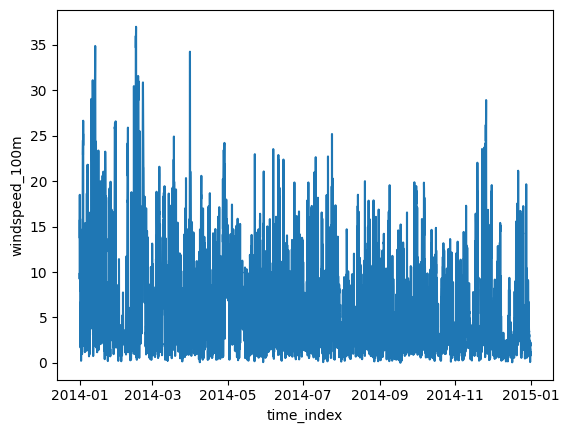

In [15]:
data = coords_df.reset_index()
y_colname = list(data)[1]
data.rename(columns={y_colname: 'windspeed_100m'}, inplace=True)
sns.lineplot(x="time_index", y="windspeed_100m", data=data)
plt.show()

In [16]:
# WindX can also filter on differnt meta data columns
region = 'Colorado'
with WindX(wtk_file, hsds=True) as f:
    date = '2014-07-04 18:00:00'
    wspd_map = f.get_timestep_map('windspeed_100m', date, region=region,
                                  region_col='state')

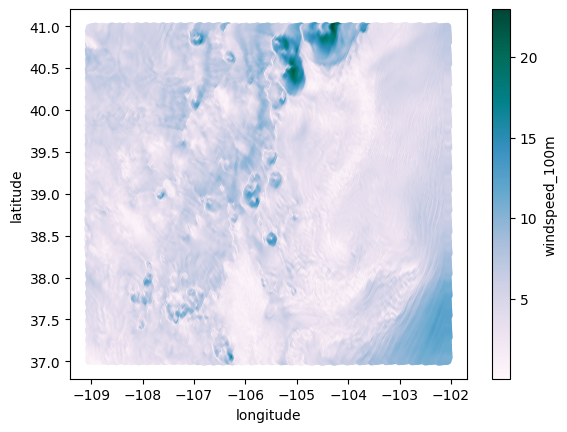

In [17]:
wspd_map.plot.scatter(x='longitude', y='latitude', c='windspeed_100m', colormap='PuBuGn')
plt.show()

In [18]:
# WindX can also extract the variables need for SAM
nwtc = (39.913561, -105.222422)
with WindX(wtk_file, hsds=True) as f:
    nrel_sam_vars = f.get_SAM_lat_lon(100, nwtc)

In [19]:
nrel_sam_vars

,Year,Month,Day,Hour,Pressure,Temperature,Speed
0,2014,1,1,0,0.793980,5.97,3.21
1,2014,1,1,1,0.794078,5.86,2.61
2,2014,1,1,2,0.794473,5.47,4.11
3,2014,1,1,3,0.794473,4.15,2.30
4,2014,1,1,4,0.794868,3.43,2.90
...,...,...,...,...,...,...,...
8755,2014,12,31,19,0.795164,6.84,4.68
8756,2014,12,31,20,0.794670,6.54,8.04
8757,2014,12,31,21,0.794473,6.61,6.71
8758,2014,12,31,22,0.794473,6.55,8.06
